In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os
import feather
from fastai.text import *

from petfinder.data import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
path = 'C:\\work\\ML\\PetFinder\\'
bs=64

pets = get_data(isTest=False)
petsTest = get_data(isTest=True)

petsTest['AdoptionSpeed'] = 0

# Language Model

First let's handle our language model.  In fast.ai, you can use a pre-trained language model called ULMFit trained on all the text of wikipedia on trying to predict the next word in a sentence.  In our case we don't want to predict the next word in a sentence, but we want to use what this language model learned to help us with our task of predicting how fast a pet is going to get adopted.

In fast.ai, you can fine-tune a pre-trained model on your own corpora of text to make it better at handling your own domain.  In our case, descriptions of pets.

We are going to use the description from both the training and test set to fine tune this pre-trained model to give us as much text as possible to fine tune it.

In [3]:
petsAll = pd.concat([pets, petsTest])
petsAll = petsAll.dropna(subset=['Description'])

descriptions = petsAll.groupby(['PetID', 'Description']).size().to_frame().reset_index().set_index('PetID')

Then let's prepare a DataBunch for those description.  Basically in the background fastai is tokenizing this text and numericalize it to make it usesable by the neural network.  This DataBunch is also going to be used to know our vocabulary (what word does this language model know) later on when we are going to use it in our network.

In [4]:
data_lm = (TextList.from_df(descriptions, cols='Description').split_by_rand_pct(0.1).label_for_lm().databunch(bs=bs, path=path))
data_lm.save('data_lm_descriptions.pkl')

In [5]:
data_lm = load_data(path, 'data_lm_descriptions.pkl', bs=bs)

In [6]:
data_lm.show_batch()

idx,text
0,"beach .. xxmaj adopters must vaccinate , spay and keep puppy indoors / fenced xxmaj call / whatsapp : xxmaj address : teluk xxunk xxbos xxmaj cherry was a stray dog we rescued from the streets . xxmaj she behaves like a total house pet , who would believe she used to stray for a year plus ! xxmaj cherry loves to be indoor , loves to be near human"
1,"fine ) . xxmaj the owner is xxmaj korean lady , a mother of 2 babies - 18 months and 6 months and she 's pregnant again so planning to go back to xxmaj korea . xxmaj please contact if you are interested . xxbos xxmaj she is very friendly and cute . xxmaj because i want to move , the new apartment can not raise a cat , no"
2,"was rescued . i have no heart to put him back on the street after neuturing . xxmaj he will not be able to survive . i knw for a fact , he has an owner before he was abandoned . xxmaj will you be able to give xxmaj luke a forever home .. let him feel the love he used to have ? xxmaj give me a call at"
3,"including xxmaj xxunk xxup xxunk have to direct part order from xxmaj xxunk and waited for 3 weeks long to reached xxmaj malaysia . xxmaj ha ! xxmaj ha ! xxmaj ha ! xxup what a xxup good xxup laugh xxbos xxmaj happy yappy 4 month old puppies were dumped at the pet clinic mercilessly . 4 months later , these 4 puppies have grown to be the lovable xxmaj"
4,"facilitate the adopter to be entitled for the starter pack , cos posting in a group only entitles one adopter . xxbos xxmaj nak bagi pet ni sebab dah banyak sgt . lagipun mase x cukup nak jaga .. my pet betul2 tak terurus sekarang ... call . i tinggal area segambut , kl . xxup telah xxup selamat xxup di xxup rumah xxup baru xxrep 4 . xxbos xxmaj"


## Language model fine-tuning

In [7]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


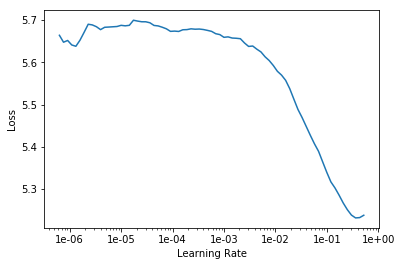

In [8]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [9]:
lr = 5e-2

In [10]:
learn.fit_one_cycle(1, lr, moms=(.8, .7))

epoch,train_loss,valid_loss,accuracy,time
0,3.726701,3.443351,0.347794,00:44


In [11]:
learn.save('fit_head')
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (17069 items)
x: LMTextList
xxbos xxmaj xxunk was rescued from the construction site behind my house . xxmaj he is quite the manja type and loves to play . xxmaj he makes a good companion and playmate for young children . xxmaj he is quite the handsome chap with a distinct mark on his face like a beauty mark .,xxbos went to teluk xxunk xxunk restaurant saw this female puppies alone by the beach .. xxmaj adopters must vaccinate , spay and keep puppy indoors / fenced xxmaj call / whatsapp : xxmaj address : teluk xxunk,xxbos xxmaj cherry was a stray dog we rescued from the streets . xxmaj she behaves like a total house pet , who would believe she used to stray for a year plus ! xxmaj cherry loves to be indoor , loves to be near human , loves human touches , loves other dogs . xxmaj we are looking for a forever home that could continue letting xxmaj cherry do all that she loves . xxmaj we want to find xxmaj cherry a home which will tr

In [12]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.376002,3.337966,0.360892,00:59
1,3.218935,3.198084,0.380810,00:58
2,3.088321,3.087903,0.397807,00:58
3,2.900379,3.020042,0.408955,01:00
4,2.775925,2.984735,0.416367,00:59
5,2.651721,2.965952,0.419984,00:59
6,2.546253,2.963663,0.422052,01:00
7,2.471917,2.963549,0.422827,00:59
8,2.399469,2.967543,0.423779,00:59
9,2.376323,2.971359,0.423615,01:00


Here the most important part is save_encoder.  We are saving the part of the language model responsible to encode this sentence into a tensor of information.  We are going to using this fine-tuned encoder in some other part of the neural network.

In [13]:
learn.save('fine_tuned')
learn.save_encoder('fine_tuned_enc')